In [1]:
%pip install networkx scipy
%pip install plotly
%pip install pyvis
%pip install scikit-learn scipy seaborn
%pip install -U kaleido
%pip install matplotlib
%pip install pandas
%pip install numpy
%pip install scikit-bio
%pip install qiime2
%pip install qiime2-plugin-diversity
%pip install statannotations scikit-bio
%pip install pydeseq2



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement qiime2 (from versions: none)
ERROR: No matching distribution found for qiime2
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement qiime2-plugin-diversity (from versions: none)
ERROR: No matching distribution found for qiime2-plugin-diversity
Note: you may need to re

Bins Archive

In [2]:
import os
import glob

BINS_DIR = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/taxonomy/fila_*/filtered_bins_high_quality"
OUTPUT_TSV = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/taxonomy/contigs_to_bins.tsv"

os.makedirs(os.path.dirname(OUTPUT_TSV), exist_ok=True)

# Find all fasta files
bin_files = []
for ext in ["*.fa", "*.fasta", "*.fna"]:
    bin_files.extend(glob.glob(os.path.join(BINS_DIR, ext)))

if not bin_files:
    print(f"Error: No files found in {BINS_DIR}")
else:
    contig_count = 0
    with open(OUTPUT_TSV, 'w') as out_f:
        for bin_path in bin_files:
            mag_id = os.path.splitext(os.path.basename(bin_path))[0]
            
            with open(bin_path, 'r') as f:
                for line in f:
                    if line.startswith(">"):
                        contig_id = line[1:].split()[0]
                        out_f.write(f"{contig_id}\t{mag_id}\n")
                        contig_count += 1

    print(f"Success: Mapped {contig_count} contigs from {len(bin_files)} bins to {OUTPUT_TSV}")

Success: Mapped 205428 contigs from 503 bins to /home/marcos/PRJEB59406/ORGANIZED_RESULTS/taxonomy/contigs_to_bins.tsv


In [3]:
import pandas as pd
import os
import glob

# 1. Config
FUNC_DIR = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/functional"
FILE_META = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/functional/sample_map.csv"
FILE_MAG = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/taxonomy/master_table_mag_sialidase_gtdb.csv"
FILE_C2B = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/taxonomy/contigs_to_bins.tsv" 
OUT_TSV = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/Final_Table_Taxonomy_Function_gtdb.tsv"

# 2. Helpers
def load_idxstats(path):
    df = pd.read_csv(path, sep='\t', header=None, names=['CDS', 'Length', 'Mapped', 'Unmapped'])
    return df[df['CDS'] != '*'][['CDS', 'Length', 'Mapped']]

def load_diamond(path):
    df = pd.read_csv(path, sep='\t')
    df.rename(columns={'seqid': 'CDS', 'sseqid': 'Protein', 'qseqid': 'CDS'}, inplace=True, errors='ignore')
    if 'CDS' not in df.columns:
        df = pd.read_csv(path, sep='\t', header=None)
        df.columns = ['CDS', 'Protein'] + list(df.columns[2:])
    return df[['CDS', 'Protein']]

def calculate_tpm(df):
    df['RPK'] = df['Mapped'] / (df['Length'] / 1000)
    sf = df['RPK'].sum() / 1e6
    df['TPM'] = df['RPK'] / sf if sf > 0 else 0.0
    return df

# 3. Extract & Calculate TPM
print("Processing functional files...")
all_cds = []
# O glob vai iterar sobre fila_1, fila_2, etc...
for q_dir in sorted(glob.glob(os.path.join(FUNC_DIR, "fila_*"))):
    # Aqui ele entra exatamente no caminho que você mencionou: .../fila_X/idxstats
    idx_dir, dia_dir = os.path.join(q_dir, "idxstats"), os.path.join(q_dir, "diamond_results_filtrados")
    
    for file in [f for f in os.listdir(idx_dir) if f.endswith(".idxstats.txt")]:
        sample_id = file.replace(".idxstats.txt", "").replace("_aligned_fna", "")
        idx_path, dia_path = os.path.join(idx_dir, file), os.path.join(dia_dir, f"{sample_id}_matches.tsv")

        if os.path.exists(dia_path):
            df_m = load_diamond(dia_path).merge(load_idxstats(idx_path), on='CDS', how='inner')
            df_m = calculate_tpm(df_m)
            df_m['Sample'] = sample_id
            
            # MUDANÇA: Agora mantemos a coluna 'Mapped' (Raw Counts) aqui
            all_cds.append(df_m[['CDS', 'Protein', 'TPM', 'Mapped', 'Sample']])

# MUDANÇA: Renomear TPM para Abundance e Mapped para Raw_Counts
df_base = pd.concat(all_cds, ignore_index=True).rename(columns={'TPM': 'Abundance', 'Mapped': 'Raw_Counts'})

# 4. Add Metadata
print("Integrating metadata...")
df_base['Contig_Match_ID'] = df_base['CDS'].apply(lambda x: "_".join(str(x).split('_')[:-1]))

df_meta = pd.read_csv(FILE_META, sep='\t').rename(columns={'run_accession': 'Sample'})

# MUDANÇA: Puxando diretamente Group e Group1 do seu sample_map.csv atualizado
cols_meta = ['Sample', 'Group']
if 'Group1' in df_meta.columns:
    cols_meta.append('Group1')

df_final = df_base.merge(df_meta[cols_meta], on='Sample', how='left')

# 5. Add Taxonomy
print("Integrating taxonomy...")
if os.path.exists(FILE_C2B):
    df_c2b = pd.read_csv(FILE_C2B, sep='\t', header=None, names=['Contig_Match_ID', 'mag_id_raw'])
    df_c2b['mag_id'] = df_c2b['mag_id_raw'].str.extract(r'(bin\.\d+)', expand=False).fillna(df_c2b['mag_id_raw'])
    df_final = df_final.merge(df_c2b[['Contig_Match_ID', 'mag_id']], on='Contig_Match_ID', how='left')

    df_master = pd.read_csv(FILE_MAG, sep='\t')
    df_final = df_final.merge(df_master, on='mag_id', how='left')
else:
    print("Warning: Taxonomy mapping file not found.")

df_final.fillna('', inplace=True)

# 6. Save & Display
# MUDANÇA: Incluímos 'Raw_Counts' e 'Group1' na lista final de colunas
cols = ['CDS', 'Protein', 'Abundance', 'Raw_Counts', 'Sample', 'Group', 'Group1', 'Contig_Match_ID', 'mag_id', 
        'Phylum', 'Genus', 'Species', 'has_nanH', 'has_nanE', 'has_nanK', 'has_nanA', 
        'has_nanT', 'gene_count', 'best_hit']

df_final = df_final[[c for c in cols if c in df_final.columns]]
df_final.to_csv(OUT_TSV, sep='\t', index=False)

print(f"Done. Saved to: {OUT_TSV}")
# Exibir as primeiras linhas usando display() caso esteja no Jupyter Notebook
try:
    display(df_final[df_final['Genus'] != ''].head())
except NameError:
    print(df_final[df_final['Genus'] != ''].head())

Processing functional files...
Integrating metadata...
Integrating taxonomy...


/tmp/ipykernel_20233/3860018530.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_final.fillna('', inplace=True)


Done. Saved to: /home/marcos/PRJEB59406/ORGANIZED_RESULTS/Final_Table_Taxonomy_Function_gtdb.tsv


,CDS,Protein,Abundance,Raw_Counts,Sample,Group,Group1,Contig_Match_ID,mag_id,Phylum,Genus,Species,has_nanH,has_nanE,has_nanK,has_nanA,has_nanT,gene_count,best_hit
3,k141_30031_1,nanA|E7S8F8,763.674128,14,ERR10856994,Control,Control,k141_30031,bin.2,Pseudomonadota,Moraxella_A,Moraxella_A osloensis_B,YES,YES,NO,YES,NO,47.0,nanE|A0ABS2NTC8
5,k141_30031_1,nanA|E7S8F8,763.674128,14,ERR10856994,Control,Control,k141_30031,bin.2,Pseudomonadota,Sphingomonas,Sphingomonas pseudosanguinis,YES,YES,NO,YES,NO,47.0,nanE|A0ABS2NTC8
6,k141_30031_1,nanA|E7S8F8,763.674128,14,ERR10856994,Control,Control,k141_30031,bin.2,Pseudomonadota,CALTWN01,CALTWN01 sp943913205,YES,YES,NO,YES,NO,47.0,nanE|A0ABS2NTC8
7,k141_30031_1,nanA|E7S8F8,763.674128,14,ERR10856994,Control,Control,k141_30031,bin.27,Pseudomonadota,Paracoccus,Paracoccus sanguinis,YES,YES,YES,YES,NO,192.0,nanH|nanH_47_cazy
8,k141_30031_1,nanA|E7S8F8,763.674128,14,ERR10856994,Control,Control,k141_30031,bin.27,Unknown,Unknown,Unknown,YES,YES,YES,YES,NO,192.0,nanH|nanH_47_cazy


Setup, Style & Colors

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa
from statannotations.Annotator import Annotator
from IPython.display import display

# 1. Config & Styling
INPUT_FILE = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/Final_Table_Taxonomy_Function_gtdb.tsv"
ORDER = ["Control", "AD"]
PALETTE = {"Control": "#e7b9a0", "AD": "#92a4cf"}

sns.set_theme(style="ticks", context="paper", font_scale=1.4)

# 2. Load Data
print(f"Loading data from {INPUT_FILE}...")
df_master = pd.read_csv(INPUT_FILE, sep='\t')
df_master['Group'] = pd.Categorical(df_master['Group'], categories=ORDER, ordered=True)

print(f"Loaded {len(df_master)} records.")
display(df_master.head(3))

Loading data from /home/marcos/PRJEB59406/ORGANIZED_RESULTS/Final_Table_Taxonomy_Function_gtdb.tsv...
Loaded 127365 records.


,CDS,Protein,Abundance,Raw_Counts,Sample,Group,Group1,Contig_Match_ID,mag_id,Phylum,Genus,Species,has_nanH,has_nanE,has_nanK,has_nanA,has_nanT,gene_count,best_hit
0,k141_9754_2,nanH|nanH_26799_bv,909.441459,16,ERR10856994,Control,Control,k141_9754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,k141_156087_1,nanA|A0A1Z5AWW6,3714.926996,53,ERR10856994,Control,Control,k141_156087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,k141_126949_1,nanH|nanH_60894_bv,777.467914,10,ERR10856994,Control,Control,k141_126949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Load Data & Calculate Alpha Diversity

## ACE (Abundance-based Coverage Estimator)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC vs. AD-NL: Mann-Whitney-Wilcoxon test two-sided, P_val:1.160e-01 U_stat=7.680e+02
AD-NL vs. AD-L: Mann-Whitney-Wilcoxon test two-sided, P_val:1.150e-01 U_stat=2.190e+02
NC vs. AD-L: Mann-Whitney-Wilcoxon test two-sided, P_val:9.916e-03 U_stat=3.490e+02


/tmp/ipykernel_20233/2267030155.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data, x='Group_3', y=metric, order=ORDER, palette=PALETTE, width=0.6, fliersize=0)


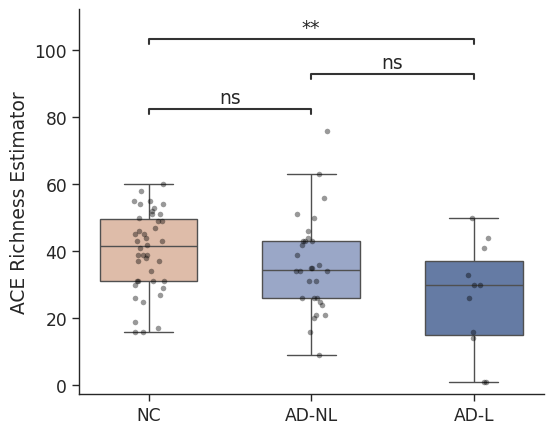

/tmp/ipykernel_20233/2267030155.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data, x='Group_3', y=metric, order=ORDER, palette=PALETTE, width=0.6, fliersize=0)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC vs. AD-NL: Mann-Whitney-Wilcoxon test two-sided, P_val:8.505e-01 U_stat=6.470e+02
AD-NL vs. AD-L: Mann-Whitney-Wilcoxon test two-sided, P_val:2.836e-02 U_stat=2.400e+02
NC vs. AD-L: Mann-Whitney-Wilcoxon test two-sided, P_val:1.632e-02 U_stat=3.410e+02


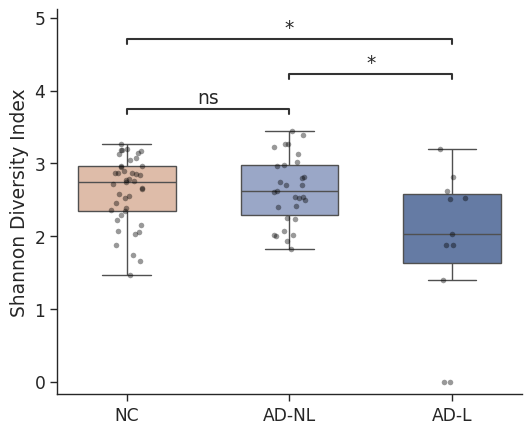

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import os

# 1. Config & Metadata
INPUT_FILE = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/Final_Table_Taxonomy_Function_gtdb.tsv"
META_FILE = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/functional/sample_map.csv"
OUT_DIR = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/figures/gtdb_quality/"
os.makedirs(OUT_DIR, exist_ok=True)

# Define order and colors for 3 groups
ORDER = ["NC", "AD-NL", "AD-L"]
PALETTE = {"NC": "#e7b9a0", "AD-NL": "#92a4cf", "AD-L": "#5a78af"}

# 2. Load Data and Apply Group Logic
df_master = pd.read_csv(INPUT_FILE, sep='\t')
meta = pd.read_csv(META_FILE, sep='\t')

# Apply the 3-group logic (NC, AD-NL, AD-L)
meta['Group_3'] = meta.apply(lambda r: 'NC' if r['Group'] == 'Control' else ('AD-NL' if 'NL' in str(r['sample_title']) else 'AD-L'), axis=1)
sample_to_group3 = dict(zip(meta['run_accession'], meta['Group_3']))

# Labeling Function
def get_label(x):
    sp, gen, mag = str(x.get('Species','')).strip(), str(x.get('Genus','')).strip(), str(x.get('mag_id','')).strip()
    if sp and sp != 'nan' and len(sp) > 3: return sp
    if gen and gen != 'nan': return f"{gen} ({mag})"
    return f"Unknown ({mag})" if mag != 'nan' else "Unbinned"

df_master['Label'] = df_master.apply(get_label, axis=1)
df_master['Group_3'] = df_master['Sample'].map(sample_to_group3)

# Create df_taxa grouped by the 3 groups
df_taxa = df_master.groupby(['Sample', 'Group_3', 'Label'], observed=True)['Abundance'].sum().reset_index()

# 3. ACE Calculation Function
def calculate_ace(counts):
    counts = counts[counts > 0]
    if len(counts) == 0: return 0
    n_rare = counts[counts <= 10].sum()
    s_rare = len(counts[counts <= 10])
    s_abund = len(counts[counts > 10])
    if n_rare == 0 or s_rare < 2: return s_rare + s_abund
    f1 = len(counts[counts == 1])
    c_ace = 1 - (f1 / n_rare) if n_rare > 0 else 1
    sum_i = sum(i * (i - 1) * len(counts[counts == i]) for i in range(1, 11))
    gamma_ace = max(0, (s_rare / c_ace) * (sum_i / (n_rare * (n_rare - 1))) - 1)
    return s_abund + (s_rare / c_ace) + (f1 / c_ace) * gamma_ace

# 4. Diversity Calculation
matrix = df_taxa.pivot_table(index='Sample', columns='Label', values='Abundance', fill_value=0)

alpha_df = pd.DataFrame({
    'ACE': matrix.apply(calculate_ace, axis=1),
    'Shannon': matrix.apply(lambda r: -np.sum((p := r[r > 0] / r.sum()) * np.log(p)) if r.sum() > 0 else 0, axis=1),
    'Group_3': matrix.index.map(sample_to_group3)
})

# 5. Plotting Function for 3 Groups
def plot_alpha_3groups(data, metric, ylabel, filename):
    plt.figure(figsize=(6, 5))
    
    # Boxplot and data points
    ax = sns.boxplot(data=data, x='Group_3', y=metric, order=ORDER, palette=PALETTE, width=0.6, fliersize=0)
    sns.stripplot(data=data, x='Group_3', y=metric, order=ORDER, color="black", size=4, alpha=0.4, ax=ax)
    
    # Statistical Pairs (Comparing all 3 combinations)
    pairs = [("NC", "AD-NL"), ("NC", "AD-L"), ("AD-NL", "AD-L")]
    
    try:
        annotator = Annotator(ax, pairs, data=data, x='Group_3', y=metric, order=ORDER)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='inside').apply_and_annotate()
    except Exception as e:
        print(f"Stats warning for {metric}: {e}")
    
    ax.set(xlabel="", ylabel=ylabel)
    sns.despine()
    plt.savefig(os.path.join(OUT_DIR, filename), bbox_inches='tight')
    plt.show()

# 6. Generate Final Plots
plot_alpha_3groups(alpha_df, 'ACE', 'ACE Richness Estimator', 'Fig1a_ACE_3groups.svg')
plot_alpha_3groups(alpha_df, 'Shannon', 'Shannon Diversity Index', 'Fig1b_Shannon_3groups.svg')

## Margalef’s richness 

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC vs. AD-NL: Mann-Whitney-Wilcoxon test two-sided, P_val:1.012e-01 U_stat=7.740e+02
AD-NL vs. AD-L: Mann-Whitney-Wilcoxon test two-sided, P_val:1.535e-01 U_stat=2.140e+02
NC vs. AD-L: Mann-Whitney-Wilcoxon test two-sided, P_val:9.351e-03 U_stat=3.500e+02


/tmp/ipykernel_20233/1516584021.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data, x='Group_3', y=metric, order=ORDER, palette=PALETTE, width=0.6, fliersize=0)


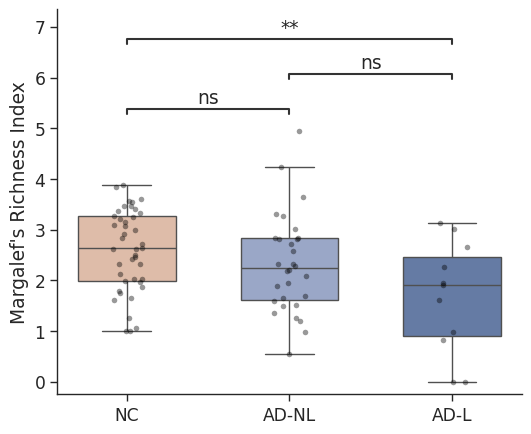

/tmp/ipykernel_20233/1516584021.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data, x='Group_3', y=metric, order=ORDER, palette=PALETTE, width=0.6, fliersize=0)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC vs. AD-NL: Mann-Whitney-Wilcoxon test two-sided, P_val:8.505e-01 U_stat=6.470e+02
AD-NL vs. AD-L: Mann-Whitney-Wilcoxon test two-sided, P_val:2.836e-02 U_stat=2.400e+02
NC vs. AD-L: Mann-Whitney-Wilcoxon test two-sided, P_val:1.632e-02 U_stat=3.410e+02


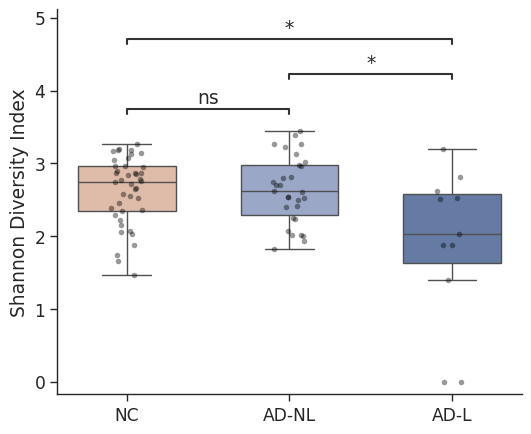

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import os

# 1. Config & Paths
INPUT_FILE = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/Final_Table_Taxonomy_Function_gtdb.tsv"
META_FILE = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/functional/sample_map.csv"
OUT_DIR = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/figures/gtdb_quality/"
os.makedirs(OUT_DIR, exist_ok=True)

ORDER = ["NC", "AD-NL", "AD-L"]
PALETTE = {"NC": "#e7b9a0", "AD-NL": "#92a4cf", "AD-L": "#5a78af"}

# 2. Data Loading and Processing
df_master = pd.read_csv(INPUT_FILE, sep='\t')
meta = pd.read_csv(META_FILE, sep='\t')

# Mapping for 3 groups
meta['Group_3'] = meta.apply(lambda r: 'NC' if r['Group'] == 'Control' else ('AD-NL' if 'NL' in str(r['sample_title']) else 'AD-L'), axis=1)
sample_to_group3 = dict(zip(meta['run_accession'], meta['Group_3']))

def get_label(x):
    sp, gen, mag = str(x.get('Species','')).strip(), str(x.get('Genus','')).strip(), str(x.get('mag_id','')).strip()
    if sp and sp != 'nan' and len(sp) > 3: return sp
    if gen and gen != 'nan': return f"{gen} ({mag})"
    return f"Unknown ({mag})" if mag != 'nan' else "Unbinned"

df_master['Label'] = df_master.apply(get_label, axis=1)
df_master['Group_3'] = df_master['Sample'].map(sample_to_group3)

# 3. Diversity Functions
def calculate_margalef(counts):
    """Calculates Margalef's Richness Index: (S - 1) / ln(N)"""
    s = np.count_nonzero(counts) # Species Richness
    n = np.sum(counts)           # Total Abundance
    if n <= 1 or s <= 1: return 0
    return (s - 1) / np.log(n)

def calculate_shannon(counts):
    """Calculates Shannon Diversity Index"""
    counts = counts[counts > 0]
    p = counts / np.sum(counts)
    return -np.sum(p * np.log(p))

# 4. Matrix and Alpha Diversity Calculation
df_taxa = df_master.groupby(['Sample', 'Group_3', 'Label'], observed=True)['Abundance'].sum().reset_index()
matrix = df_taxa.pivot_table(index='Sample', columns='Label', values='Abundance', fill_value=0)

alpha_df = pd.DataFrame({
    'Margalef': matrix.apply(calculate_margalef, axis=1),
    'Shannon': matrix.apply(calculate_shannon, axis=1),
    'Group_3': matrix.index.map(sample_to_group3)
})

# 5. Plotting Function
def plot_alpha_final(data, metric, ylabel, filename):
    plt.figure(figsize=(6, 5))
    ax = sns.boxplot(data=data, x='Group_3', y=metric, order=ORDER, palette=PALETTE, width=0.6, fliersize=0)
    sns.stripplot(data=data, x='Group_3', y=metric, order=ORDER, color="black", size=4, alpha=0.4, ax=ax)
    
    pairs = [("NC", "AD-NL"), ("NC", "AD-L"), ("AD-NL", "AD-L")]
    annotator = Annotator(ax, pairs, data=data, x='Group_3', y=metric, order=ORDER)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside').apply_and_annotate()
    
    ax.set(xlabel="", ylabel=ylabel)
    sns.despine()
    plt.savefig(os.path.join(OUT_DIR, filename), bbox_inches='tight')
    plt.show()

# 6. Execute
plot_alpha_final(alpha_df, 'Margalef', "Margalef's Richness Index", 'Fig1a_Margalef_3groups.svg')
plot_alpha_final(alpha_df, 'Shannon', 'Shannon Diversity Index', 'Fig1b_Shannon_3groups.svg')

In [ ]:
## Chao1

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC vs. AD-NL: Mann-Whitney-Wilcoxon test two-sided, P_val:1.160e-01 U_stat=7.680e+02
AD-NL vs. AD-L: Mann-Whitney-Wilcoxon test two-sided, P_val:1.150e-01 U_stat=2.190e+02
NC vs. AD-L: Mann-Whitney-Wilcoxon test two-sided, P_val:9.916e-03 U_stat=3.490e+02


/tmp/ipykernel_20233/657858492.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data, x='Group_3', y=metric, order=ORDER, palette=PALETTE, width=0.6, fliersize=0)


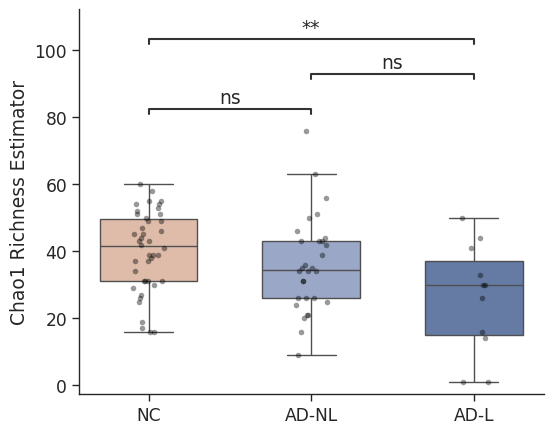

/tmp/ipykernel_20233/657858492.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data, x='Group_3', y=metric, order=ORDER, palette=PALETTE, width=0.6, fliersize=0)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC vs. AD-NL: Mann-Whitney-Wilcoxon test two-sided, P_val:8.505e-01 U_stat=6.470e+02
AD-NL vs. AD-L: Mann-Whitney-Wilcoxon test two-sided, P_val:2.836e-02 U_stat=2.400e+02
NC vs. AD-L: Mann-Whitney-Wilcoxon test two-sided, P_val:1.632e-02 U_stat=3.410e+02


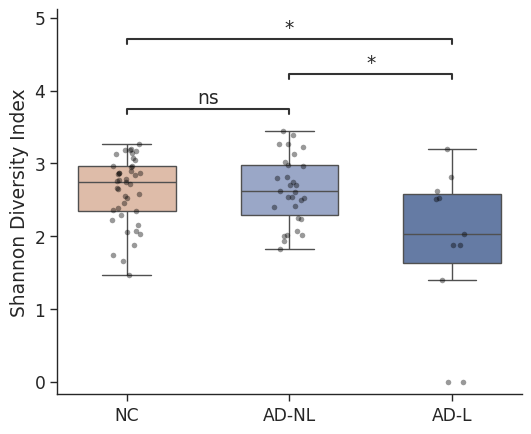

Alpha diversity plots (Chao1 & Shannon) saved to: /home/marcos/PRJEB59406/ORGANIZED_RESULTS/figures/gtdb_quality/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import os

# 1. Config & Paths
INPUT_FILE = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/Final_Table_Taxonomy_Function_gtdb.tsv"
META_FILE = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/functional/sample_map.csv"
OUT_DIR = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/figures/gtdb_quality/"
os.makedirs(OUT_DIR, exist_ok=True)

# Groups and Colors
ORDER = ["NC", "AD-NL", "AD-L"]
PALETTE = {"NC": "#e7b9a0", "AD-NL": "#92a4cf", "AD-L": "#5a78af"}

# 2. Data Loading and Processing
df_master = pd.read_csv(INPUT_FILE, sep='\t')
meta = pd.read_csv(META_FILE, sep='\t')

# Mapping for 3 groups
meta['Group_3'] = meta.apply(lambda r: 'NC' if r['Group'] == 'Control' else ('AD-NL' if 'NL' in str(r['sample_title']) else 'AD-L'), axis=1)
sample_to_group3 = dict(zip(meta['run_accession'], meta['Group_3']))

def get_label(x):
    sp, gen, mag = str(x.get('Species','')).strip(), str(x.get('Genus','')).strip(), str(x.get('mag_id','')).strip()
    if sp and sp != 'nan' and len(sp) > 3: return sp
    if gen and gen != 'nan': return f"{gen} ({mag})"
    return f"Unknown ({mag})" if mag != 'nan' else "Unbinned"

df_master['Label'] = df_master.apply(get_label, axis=1)
df_master['Group_3'] = df_master['Sample'].map(sample_to_group3)

# 3. Diversity Functions
def calculate_chao1(counts):
    """Calculates Chao1 Richness Estimator: S_obs + (n1^2 / (2 * n2))"""
    counts = counts[counts > 0]
    s_obs = len(counts)
    # n1: singletons, n2: doubletons
    n1 = np.sum(counts == 1)
    n2 = np.sum(counts == 2)
    
    if n2 > 0:
        return s_obs + (n1**2 / (2 * n2))
    else:
        # Bias-corrected version if n2 is 0
        return s_obs + (n1 * (n1 - 1)) / (2 * (n2 + 1))

def calculate_shannon(counts):
    """Calculates Shannon Diversity Index"""
    counts = counts[counts > 0]
    p = counts / np.sum(counts)
    return -np.sum(p * np.log(p))

# 4. Matrix and Alpha Diversity Calculation
df_taxa = df_master.groupby(['Sample', 'Group_3', 'Label'], observed=True)['Abundance'].sum().reset_index()
matrix = df_taxa.pivot_table(index='Sample', columns='Label', values='Abundance', fill_value=0)

alpha_df = pd.DataFrame({
    'Chao1': matrix.apply(calculate_chao1, axis=1),
    'Shannon': matrix.apply(calculate_shannon, axis=1),
    'Group_3': matrix.index.map(sample_to_group3)
})

# 5. Plotting Function
def plot_alpha_final(data, metric, ylabel, filename):
    plt.figure(figsize=(6, 5))
    ax = sns.boxplot(data=data, x='Group_3', y=metric, order=ORDER, palette=PALETTE, width=0.6, fliersize=0)
    sns.stripplot(data=data, x='Group_3', y=metric, order=ORDER, color="black", size=4, alpha=0.4, ax=ax)
    
    pairs = [("NC", "AD-NL"), ("NC", "AD-L"), ("AD-NL", "AD-L")]
    
    try:
        annotator = Annotator(ax, pairs, data=data, x='Group_3', y=metric, order=ORDER)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='inside').apply_and_annotate()
    except: pass
    
    ax.set(xlabel="", ylabel=ylabel)
    sns.despine()
    plt.savefig(os.path.join(OUT_DIR, filename), bbox_inches='tight')
    plt.show()

# 6. Execute
plot_alpha_final(alpha_df, 'Chao1', 'Chao1 Richness Estimator', 'Fig1a_Chao1_3groups.svg')
plot_alpha_final(alpha_df, 'Shannon', 'Shannon Diversity Index', 'Fig1b_Shannon_3groups.svg')

print(f"Alpha diversity plots (Chao1 & Shannon) saved to: {OUT_DIR}")

Calculating Bray-Curtis Dissimilarity...


/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(
/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:275: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.16919384115445563 whereas the largest positive one is 5.182255002702381.
  warn(


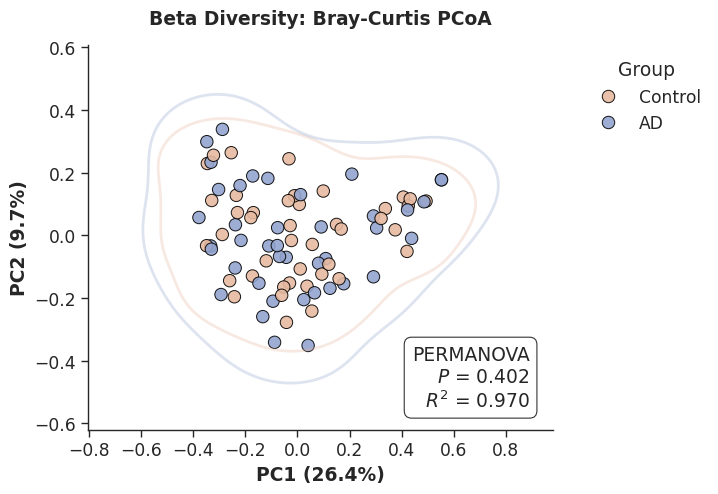

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import permanova
from skbio.stats.ordination import pcoa
from skbio import DistanceMatrix

# 1. Labeling and Data Preparation
def get_label(x):
    sp, gen, mag = str(x.get('Species','')).strip(), str(x.get('Genus','')).strip(), str(x.get('mag_id','')).strip()
    if sp and sp != 'nan' and len(sp) > 3: return sp
    if gen and gen != 'nan': return f"{gen} ({mag})"
    return f"Unknown ({mag})" if mag != 'nan' else "Unbinned"

# Step A: Applying labels and grouping to ensure df_taxa exists
if 'Label' not in df_master.columns:
    df_master['Label'] = df_master.apply(get_label, axis=1)

# Grouping by sample and taxa to sum abundances
df_taxa = df_master.groupby(['Sample', 'Group', 'Label'], observed=True)['Abundance'].sum().reset_index()

# 2. Matrix Generation for Bray-Curtis
# Rows = Samples, Columns = Bacteria Labels, Values = TPM Abundance
matrix = df_taxa.pivot_table(index='Sample', columns='Label', values='Abundance', fill_value=0)

# Mapping groups for PERMANOVA
groups = matrix.index.map(df_master.drop_duplicates('Sample').set_index('Sample')['Group'])

# 3. Distance Calculation & Statistics
print("Calculating Bray-Curtis Dissimilarity...")
# pdist calculates the condensed distance matrix
dist_array = pdist(matrix.values, metric='braycurtis')
dm = DistanceMatrix(squareform(dist_array), ids=matrix.index)

# PERMANOVA test to check if groups are significantly different
stats_res = permanova(dm, grouping=groups.values, permutations=999)
p_val, r2 = stats_res['p-value'], stats_res['test statistic']

# 4. PCoA Ordination
pcoa_res = pcoa(dm)
pcoa_df = pcoa_res.samples[['PC1', 'PC2']].assign(Group=groups.values)
var_exp = pcoa_res.proportion_explained

# 5. Visualization (Control vs AD)
ORDER, PALETTE = ["Control", "AD"], {"Control": "#e7b9a0", "AD": "#92a4cf"}

plt.figure(figsize=(6, 5))
sns.scatterplot(data=pcoa_df, x='PC1', y='PC2', hue='Group', hue_order=ORDER, 
                palette=PALETTE, s=80, edgecolor='black', alpha=0.9)

# Adding KDE density contours to highlight group clusters
for g in ORDER:
    subset = pcoa_df[pcoa_df['Group'] == g]
    if len(subset) > 3:
        sns.kdeplot(x=subset['PC1'], y=subset['PC2'], levels=1, 
                    color=PALETTE[g], alpha=0.3, linewidths=2)

# Formatting axes with Explained Variance
plt.xlabel(f"PC1 ({var_exp['PC1']:.1%})", fontweight='bold')
plt.ylabel(f"PC2 ({var_exp['PC2']:.1%})", fontweight='bold')
plt.title("Beta Diversity: Bray-Curtis PCoA", fontweight='bold', pad=15)

# Adding statistical results box
plt.text(0.95, 0.05, f"PERMANOVA\n$P$ = {p_val:.3f}\n$R^2$ = {r2:.3f}", 
         transform=plt.gca().transAxes, ha='right', va='bottom', 
         bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=0.8))

plt.legend(title="Group", frameon=False, loc='upper left', bbox_to_anchor=(1.05, 1))
sns.despine()

# Save Figure
OUT_DIR = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/figures/gtdb_quality/"
os.makedirs(OUT_DIR, exist_ok=True)
plt.savefig(os.path.join(OUT_DIR, 'Fig1c_PCoA_BrayCurtis.svg'), bbox_inches='tight')
plt.show()

Calculating Bray-Curtis Dissimilarity for 3 Groups...


/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(
/home/marcos/miniconda3/envs/bowtie2/lib/python3.14/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:275: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.16919384115445563 whereas the largest positive one is 5.182255002702381.
  warn(


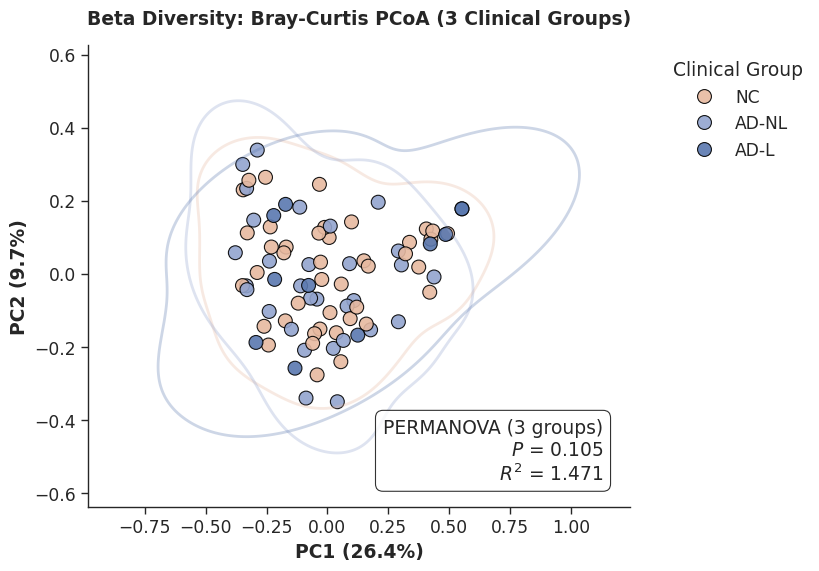

PCoA for 3 groups saved to: /home/marcos/PRJEB59406/ORGANIZED_RESULTS/figures/gtdb_quality/Fig1c_PCoA_BrayCurtis_3groups.svg


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import permanova
from skbio.stats.ordination import pcoa
from skbio import DistanceMatrix

# 1. Config & Metadata Integration
META_FILE = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/functional/sample_map.csv"
OUT_DIR = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/figures/gtdb_quality/"
os.makedirs(OUT_DIR, exist_ok=True)

# Load metadata and define the 3 groups logic
meta = pd.read_csv(META_FILE, sep='\t')
meta['Group_3'] = meta.apply(lambda r: 'NC' if r['Group'] == 'Control' else ('AD-NL' if 'NL' in str(r['sample_title']) else 'AD-L'), axis=1)
sample_to_group3 = dict(zip(meta['run_accession'], meta['Group_3']))

# 2. Labeling and Data Preparation
def get_label(x):
    sp, gen, mag = str(x.get('Species','')).strip(), str(x.get('Genus','')).strip(), str(x.get('mag_id','')).strip()
    if sp and sp != 'nan' and len(sp) > 3: return sp
    if gen and gen != 'nan': return f"{gen} ({mag})"
    return f"Unknown ({mag})" if mag != 'nan' else "Unbinned"

# Step A: Applying labels and Group_3 to df_master
if 'Label' not in df_master.columns:
    df_master['Label'] = df_master.apply(get_label, axis=1)

df_master['Group_3'] = df_master['Sample'].map(sample_to_group3)

# Grouping by sample and taxa
df_taxa = df_master.groupby(['Sample', 'Group_3', 'Label'], observed=True)['Abundance'].sum().reset_index()

# 3. Matrix Generation for Bray-Curtis
matrix = df_taxa.pivot_table(index='Sample', columns='Label', values='Abundance', fill_value=0)
groups = matrix.index.map(sample_to_group3)

# 4. Distance Calculation & Statistics (PERMANOVA)
print("Calculating Bray-Curtis Dissimilarity for 3 Groups...")
dist_array = pdist(matrix.values, metric='braycurtis')
dm = DistanceMatrix(squareform(dist_array), ids=matrix.index)

# PERMANOVA test for the 3 groups
stats_res = permanova(dm, grouping=groups.values, permutations=999)
p_val, r2 = stats_res['p-value'], stats_res['test statistic']

# 5. PCoA Ordination
pcoa_res = pcoa(dm)
pcoa_df = pcoa_res.samples[['PC1', 'PC2']].assign(Group=groups.values)
var_exp = pcoa_res.proportion_explained

# 6. Visualization (NC vs AD-NL vs AD-L)
ORDER = ["NC", "AD-NL", "AD-L"]
PALETTE = {"NC": "#e7b9a0", "AD-NL": "#92a4cf", "AD-L": "#5a78af"}

plt.figure(figsize=(7, 6))
sns.scatterplot(data=pcoa_df, x='PC1', y='PC2', hue='Group', hue_order=ORDER, 
                palette=PALETTE, s=100, edgecolor='black', alpha=0.9)

# Adding KDE density contours for each of the 3 groups
for g in ORDER:
    subset = pcoa_df[pcoa_df['Group'] == g]
    if len(subset) > 3:
        sns.kdeplot(x=subset['PC1'], y=subset['PC2'], levels=1, 
                    color=PALETTE[g], alpha=0.3, linewidths=2)

# Formatting
plt.xlabel(f"PC1 ({var_exp['PC1']:.1%})", fontweight='bold')
plt.ylabel(f"PC2 ({var_exp['PC2']:.1%})", fontweight='bold')
plt.title("Beta Diversity: Bray-Curtis PCoA (3 Clinical Groups)", fontweight='bold', pad=15)

# Stats box
plt.text(0.95, 0.05, f"PERMANOVA (3 groups)\n$P$ = {p_val:.3f}\n$R^2$ = {r2:.3f}", 
         transform=plt.gca().transAxes, ha='right', va='bottom', 
         bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=0.8))

plt.legend(title="Clinical Group", frameon=False, loc='upper left', bbox_to_anchor=(1.05, 1))
sns.despine()

# Save Figure
out_path = os.path.join(OUT_DIR, 'Fig1c_PCoA_BrayCurtis_3groups.svg')
plt.savefig(out_path, bbox_inches='tight')
plt.show()

print(f"PCoA for 3 groups saved to: {out_path}")

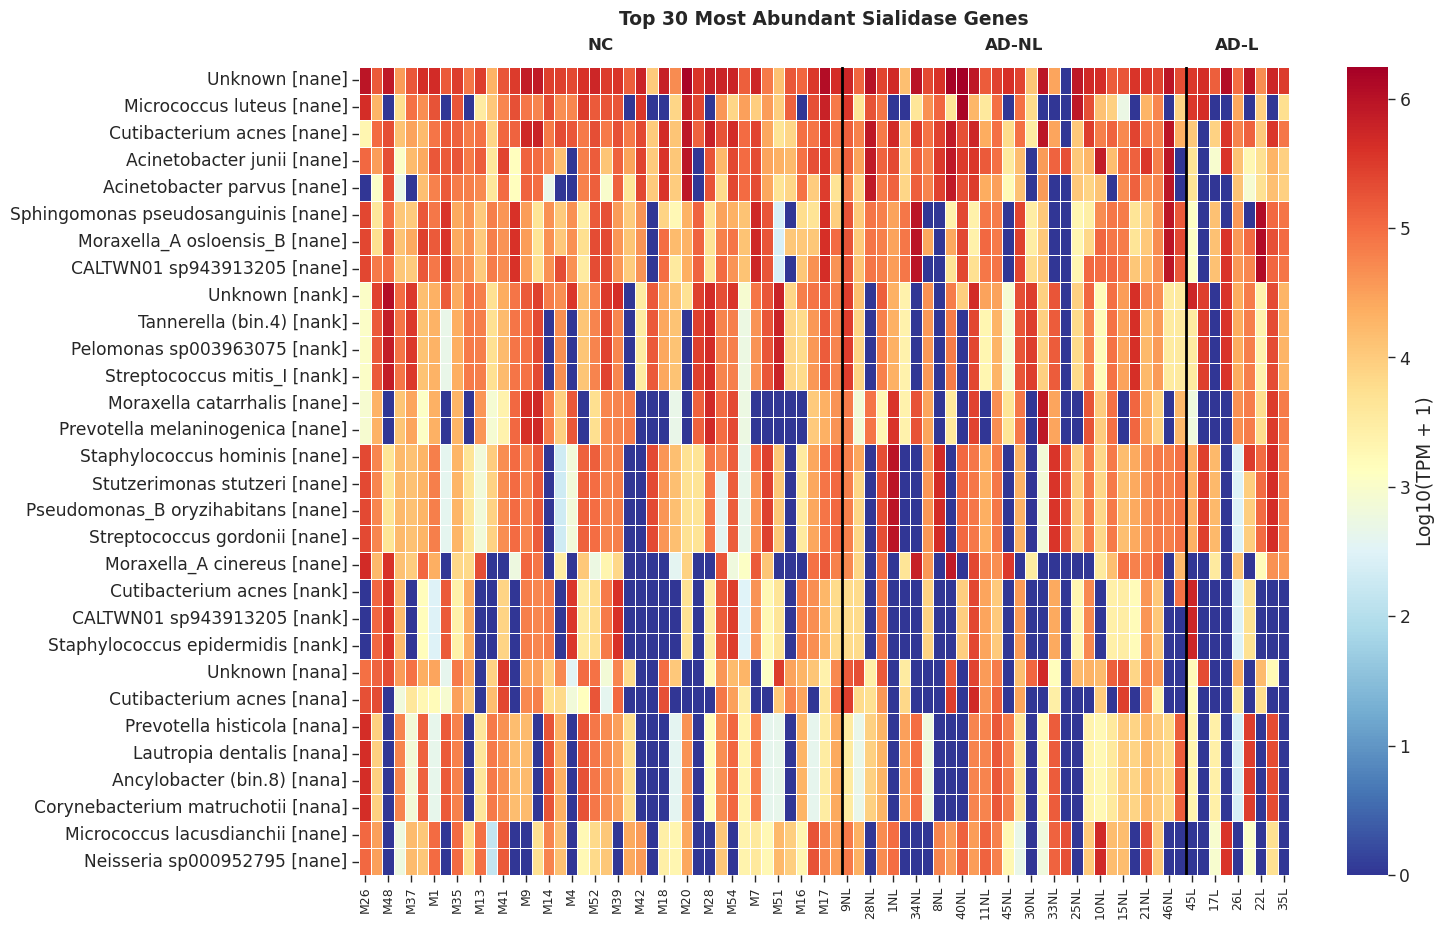

Saved to: /home/marcos/PRJEB59406/ORGANIZED_RESULTS/figures/gtdb_quality/Fig2_Top30_Genes_Heatmap.svg


In [ ]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import leaves_list, linkage

# 1. Config
INPUT_FILE = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/Final_Table_Taxonomy_Function_gtdb.tsv"
META_FILE = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/functional/sample_map.csv"
OUT_DIR = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/figures/gtdb_quality/"
os.makedirs(OUT_DIR, exist_ok=True)

# 2. Load & Format
df = pd.read_csv(INPUT_FILE, sep='\t')
meta = pd.read_csv(META_FILE, sep='\t')

# Map groups (NC, AD-NL, AD-L)
meta['Group_3'] = meta.apply(lambda r: 'NC' if r['Group'] == 'Control' else ('AD-NL' if 'NL' in str(r['sample_title']) else 'AD-L'), axis=1)
df['sample_title'] = df['Sample'].map(dict(zip(meta['run_accession'], meta['sample_title']))).fillna(df['Sample'])
df['Group_3'] = df['sample_title'].map(dict(zip(meta['sample_title'], meta['Group_3'])))

# Extract specific nan genes
gene_col = 'best_hit' if 'best_hit' in df.columns else 'Protein'
df['Gene'] = df[gene_col].apply(lambda x: m.group(1).lower() if (m := re.search(r'(nan[AEKHT])', str(x), re.I)) else 'other')
df = df[df['Gene'] != 'other']

# Create Label (Taxa + Gene)
def get_taxa_label(x):
    sp, gen, mag = str(x.get('Species','')).strip(), str(x.get('Genus','')).strip(), str(x.get('mag_id','')).strip()
    if sp and sp != 'nan' and len(sp) > 3: return sp
    if gen and gen != 'nan': return f"{gen} ({mag})"
    return "Unbinned"

df['Taxa'] = df.apply(get_taxa_label, axis=1)
df = df[df['Taxa'] != "Unbinned"]
df['Label'] = df['Taxa'] + " [" + df['Gene'] + "]"

# 3. Top 30 Matrix Generation
matrix = df.groupby(['sample_title', 'Group_3', 'Label'], observed=True)['Abundance'].sum().reset_index() \
           .pivot(index='Label', columns='sample_title', values='Abundance').fillna(0)

# Reorder columns by group
samples = {g: meta[meta['Group_3'] == g]['sample_title'].tolist() for g in ['NC', 'AD-NL', 'AD-L']}
valid_samples = [s for g in samples.values() for s in g if s in matrix.columns]
matrix = matrix[valid_samples]

# Select Top 30 most abundant and cluster rows hierarchically
top_30 = matrix.sum(axis=1).nlargest(30).index
heatmap_data = matrix.loc[top_30]
heatmap_data = heatmap_data.iloc[leaves_list(linkage(heatmap_data.values, method='average'))]

# 4. Plotting
plt.figure(figsize=(15, max(6, len(heatmap_data) * 0.35)))
ax = sns.heatmap(np.log10(heatmap_data + 1), cmap='RdYlBu_r', cbar_kws={'label': 'Log10(TPM + 1)'}, 
                 linewidths=0.5, linecolor='white')

# Group separators & labels
nc_c = len([s for s in samples['NC'] if s in matrix.columns])
nl_c = len([s for s in samples['AD-NL'] if s in matrix.columns])
l_c  = len([s for s in samples['AD-L'] if s in matrix.columns])

ax.axvline(nc_c, color='black', lw=2)
ax.axvline(nc_c + nl_c, color='black', lw=2)

ax.text(nc_c/2, -0.5, 'NC', ha='center', va='bottom', fontweight='bold', fontsize=12)
ax.text(nc_c + nl_c/2, -0.5, 'AD-NL', ha='center', va='bottom', fontweight='bold', fontsize=12)
ax.text(nc_c + nl_c + l_c/2, -0.5, 'AD-L', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Updated title to reflect the lack of statistical filter
plt.title('Top 30 Most Abundant Sialidase Genes', fontweight='bold', pad=30)
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=90, ha='center', fontsize=9)
sns.despine(left=True, bottom=True)

out_path = os.path.join(OUT_DIR, 'Fig2_Top30_Genes_Heatmap.svg')
plt.savefig(out_path, bbox_inches='tight')
plt.show()

print(f"Saved to: {out_path}")

/tmp/ipykernel_20233/1290349881.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df['operon_score'] = df[operon_genes].applymap(lambda x: 1 if str(x).lower() in ['true', '1', 'yes'] else 0).sum(axis=1)


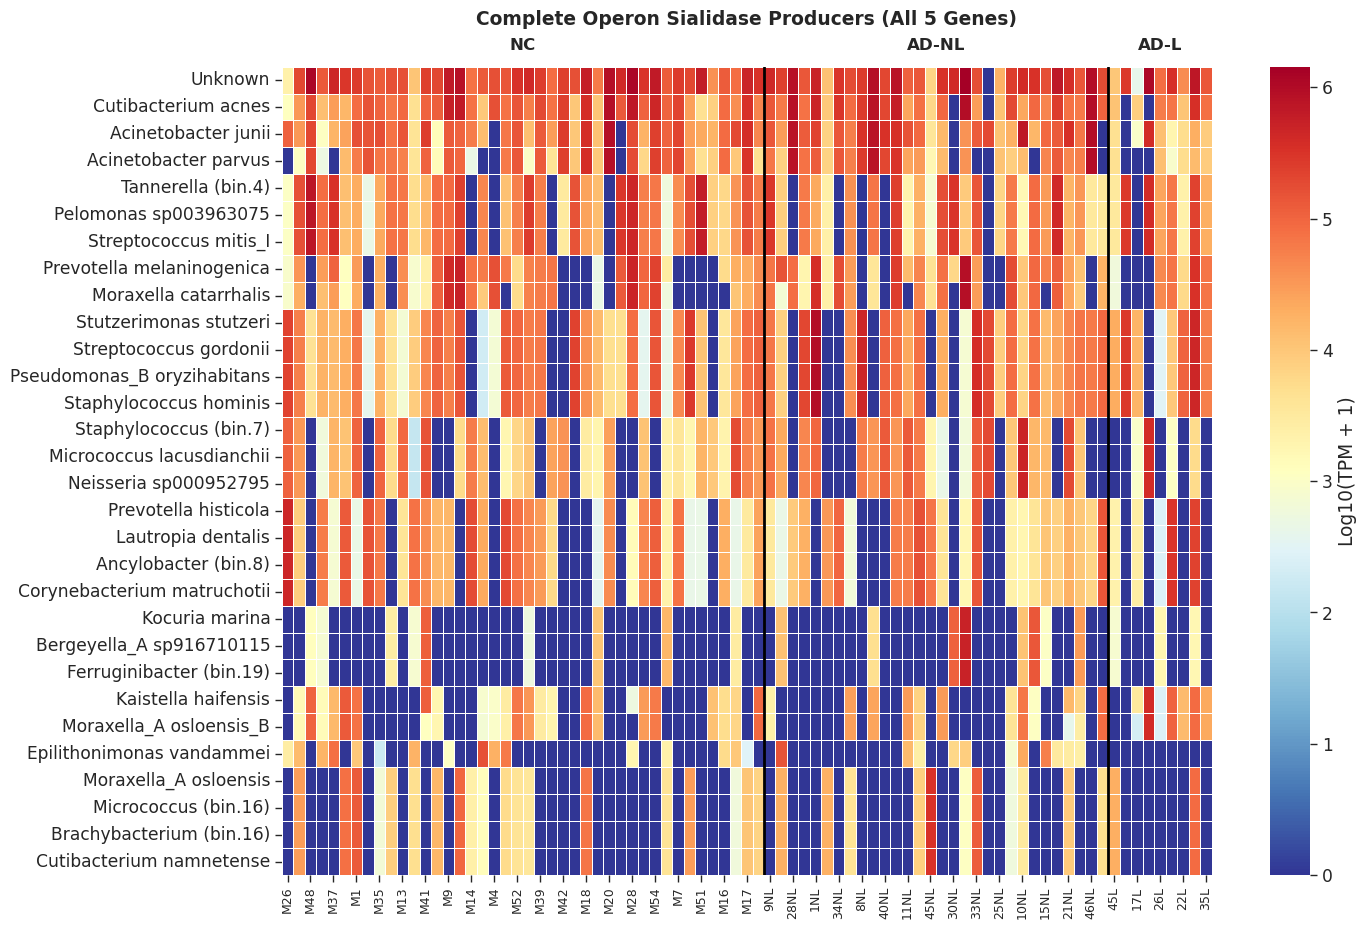

Saved to: /home/marcos/PRJEB59406/ORGANIZED_RESULTS/figures/gtdb_quality/Fig2_Complete_Operon_Heatmap.svg


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import leaves_list, linkage

# 1. Config
INPUT_FILE = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/Final_Table_Taxonomy_Function_gtdb.tsv"
META_FILE = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/functional/sample_map.csv"
OUT_DIR = "/home/marcos/PRJEB59406/ORGANIZED_RESULTS/figures/gtdb_quality/"
os.makedirs(OUT_DIR, exist_ok=True)

# 2. Load & Format
df = pd.read_csv(INPUT_FILE, sep='\t')
meta = pd.read_csv(META_FILE, sep='\t')

meta['Group_3'] = meta.apply(lambda r: 'NC' if r['Group'] == 'Control' else ('AD-NL' if 'NL' in str(r['sample_title']) else 'AD-L'), axis=1)
df['sample_title'] = df['Sample'].map(dict(zip(meta['run_accession'], meta['sample_title']))).fillna(df['Sample'])
df['Group_3'] = df['sample_title'].map(dict(zip(meta['sample_title'], meta['Group_3'])))

# 3. Filter for COMPLETE Operon (All 5 genes present)
operon_genes = ['has_nanH', 'has_nanE', 'has_nanK', 'has_nanA', 'has_nanT']

# Convert boolean/string indicators to 1 or 0 and sum them up
df['operon_score'] = df[operon_genes].applymap(lambda x: 1 if str(x).lower() in ['true', '1', 'yes'] else 0).sum(axis=1)

# KEEP ONLY taxa with all 5 genes (Score == 5)
df_complete = df[df['operon_score'] == 5].copy()

if df_complete.empty:
    print("WARNING: No bacteria found with all 5 genes! Falling back to 4 genes...")
    df_complete = df[df['operon_score'] >= 4].copy()

def get_taxa_label(x):
    sp, gen, mag = str(x.get('Species','')).strip(), str(x.get('Genus','')).strip(), str(x.get('mag_id','')).strip()
    if sp and sp != 'nan' and len(sp) > 3: return sp
    if gen and gen != 'nan': return f"{gen} ({mag})"
    return "Unbinned"

df_complete['Label'] = df_complete.apply(get_taxa_label, axis=1)
df_complete = df_complete[df_complete['Label'] != "Unbinned"]

# 4. Matrix Generation
matrix = df_complete.groupby(['sample_title', 'Group_3', 'Label'], observed=True)['Abundance'].sum().reset_index() \
           .pivot(index='Label', columns='sample_title', values='Abundance').fillna(0)

# Reorder columns by group
samples = {g: meta[meta['Group_3'] == g]['sample_title'].tolist() for g in ['NC', 'AD-NL', 'AD-L']}
valid_samples = [s for g in samples.values() for s in g if s in matrix.columns]
matrix = matrix[valid_samples]

# Optional: If still too many, keep top 30
if len(matrix) > 30:
    matrix = matrix.loc[matrix.sum(axis=1).nlargest(30).index]

# Hierarchical clustering for rows
heatmap_data = matrix.iloc[leaves_list(linkage(matrix.values, method='average'))]

# 5. Plotting
plt.figure(figsize=(15, max(6, len(heatmap_data) * 0.35)))
ax = sns.heatmap(np.log10(heatmap_data + 1), cmap='RdYlBu_r', cbar_kws={'label': 'Log10(TPM + 1)'}, 
                 linewidths=0.5, linecolor='white')

# Group separators & labels
nc_c = len([s for s in samples['NC'] if s in matrix.columns])
nl_c = len([s for s in samples['AD-NL'] if s in matrix.columns])
l_c  = len([s for s in samples['AD-L'] if s in matrix.columns])

if nc_c > 0: ax.axvline(nc_c, color='black', lw=2)
if (nc_c + nl_c) > 0: ax.axvline(nc_c + nl_c, color='black', lw=2)

ax.text(nc_c/2, -0.5, 'NC', ha='center', va='bottom', fontweight='bold', fontsize=12)
ax.text(nc_c + nl_c/2, -0.5, 'AD-NL', ha='center', va='bottom', fontweight='bold', fontsize=12)
ax.text(nc_c + nl_c + l_c/2, -0.5, 'AD-L', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.title('Complete Operon Sialidase Producers (All 5 Genes)', fontweight='bold', pad=30)
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=90, ha='center', fontsize=9)
sns.despine(left=True, bottom=True)

out_path = os.path.join(OUT_DIR, 'Fig2_Complete_Operon_Heatmap.svg')
plt.savefig(out_path, bbox_inches='tight')
plt.show()

print(f"Saved to: {out_path}")

DESeq2

In [1]:
# 1. Libraries
if(!require("BiocManager", quietly = TRUE)) install.packages("BiocManager")
if(!require("DESeq2", quietly = TRUE)) BiocManager::install("DESeq2")
library(DESeq2)

# 2. Paths and Data
setwd("~/PRJEB59406/ORGANIZED_RESULTS/functional")

matrix_counts <- read.delim("matrix_counts.tsv", header = TRUE, sep = "\t")
sample_map <- read.delim("sample_map.csv", header = TRUE, sep = "\t")

# 3. Format Count Matrix
count_mat <- as.matrix(matrix_counts[, -1])
rownames(count_mat) <- matrix_counts$Protein

# 4. Map Metadata and Rename to Sample Title
# Match the run_accession columns in count_mat to the sample_map rows
idx <- match(colnames(count_mat), sample_map$run_accession)
coldata <- sample_map[idx, c("sample_title", "Group")]

# Rename matrix columns and coldata rownames using sample_title
colnames(count_mat) <- coldata$sample_title
rownames(coldata) <- coldata$sample_title
coldata$Group <- factor(coldata$Group)

# 5. DESeq2 Object Construction
dds <- DESeqDataSetFromMatrix(
  countData = count_mat,
  colData = coldata,
  design = ~ Group
)

# "poscounts": Calculates size factors using only genes with >0 counts across all samples. 
# It is highly recommended for sparse microbiome/metagenomic data to prevent zeros from breaking the log math.
dds <- estimateSizeFactors(dds, type = "poscounts") 
dds <- DESeq(dds)

# 6. Results
res <- results(dds)
res <- res[order(res$padj), ]
summary(res)
head(res)

# 7. Transformation for plotting (e.g., PCA, Heatmaps)
vsd <- varianceStabilizingTransformation(dds, blind = TRUE)
mat <- assay(vsd) # 'mat' columns will now display 'sample_title' automatically


Anexando pacote: ‘generics’


Os seguintes objetos são mascarados por ‘package:base’:

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Anexando pacote: ‘BiocGenerics’


Os seguintes objetos são mascarados por ‘package:stats’:

    IQR, mad, sd, var, xtabs


Os seguintes objetos são mascarados por ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, saveRDS, table, tapply, unique,
    unsplit, which.max, which.min



Anexando pacote: ‘S4Vectors’


O seguinte objeto é mascarado por ‘package:utils’:

    findMatches


Os seguintes objetos são mascarados por ‘package:base’:

    expand.grid, I, unname



Anexando pacote: ‘MatrixGenerics’


Os seguintes objetos são mascarados


out of 1639 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 381, 23%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): Group Control vs AD 
Wald test p-value: Group Control vs AD 
DataFrame with 6 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat    pvalue
                <numeric>      <numeric> <numeric> <numeric> <numeric>
nanA|A0A017H2Y7  11.88387       0.434431  0.975231  0.445465  0.655984
nanA|A0A024Q8K8  44.02010      -0.427981  0.608570 -0.703257  0.481896
nanA|A0A060R935   5.50139       0.460812  1.231451  0.374202  0.708254
nanA|A0A076Z407  86.97281       0.553224  0.596235  0.927863  0.353479
nanA|A0A0A0IIG1  53.05141      -0.267786  0.555203 -0.482320  0.629578
nanA|A0A0A1M6N1  42.01003      -0.528419  0.657542 -0.803628  0.421612
                     padj
                <numeric>
nanA|A0A017H2Y7  0.998361
nanA|A0A024Q8K8  0.998361
nanA|A0A060R935  0.998361
nanA|A0A076Z407  0.998361
nanA|A0A0A0IIG1  0.998361
nanA|A0A0A1M6N1  0.998361

# Heatmap - Top protein

In [2]:
library(pheatmap)

# Top 50 most variable proteins
vars <- apply(mat, 1, var)
top <- names(sort(vars, decreasing=TRUE))[1:50]
mat_top <- mat[top, ]

# Z-score scaling per protein
mat_scaled <- t(scale(t(mat_top)))

# Annotation for clinical groups
annotation_col <- data.frame(Group = coldata$Group)
rownames(annotation_col) <- rownames(coldata)

# Plotting the Heatmap
pheatmap(mat_scaled,
         annotation_col = annotation_col,
         show_rownames = TRUE,
         show_colnames = TRUE,
         clustering_method = "ward.D2",
         fontsize_col = 4,       # Reduces the font size of sample names
         angle_col = 45,         # Rotates sample names by 45 degrees
         fontsize_row = 7,       # Reduces row font size to fit 50 proteins nicely
         main = "Top 50 Most Variable Proteins",
         filename = "Heatmap_Top50_Proteins.pdf",
         width = 10, height = 12) # Adjust dimensions for better readability


In [3]:
# 1. Transform DESeq2 results to a DataFrame for merging
res_df <- as.data.frame(res)
res_df$Protein <- rownames(res_df)

# 2. Change this path to where your taxonomy table is located
tax_table <- read.delim("~/PRJEB59406/ORGANIZED_RESULTS/Final_Table_Taxonomy_Function_gtdb.tsv", sep = "\t")

# 3. Make sure to adjust 'by.x' and 'by.y' to match the column names in your DESeq2 results and taxonomy table
crosslink_df <- merge(res_df, tax_table, by.x = "Protein", by.y = "Protein", all.x = TRUE)

# 4. Filter the crosslinked DataFrame to keep only the top 50 most variable proteins
top_50_crosslink <- crosslink_df[crosslink_df$Protein %in% top, ]

write.table(top_50_crosslink, "Top50_Proteins_with_Taxonomy.tsv", sep="\t", row.names=FALSE, quote=FALSE)

Instalando pacote em ‘/home/marcos/R/x86_64-pc-linux-gnu-library/4.5’
(como ‘lib’ não foi especificado)



[1] "Gráfico exibido na tela e salvo em formato SVG com sucesso!"


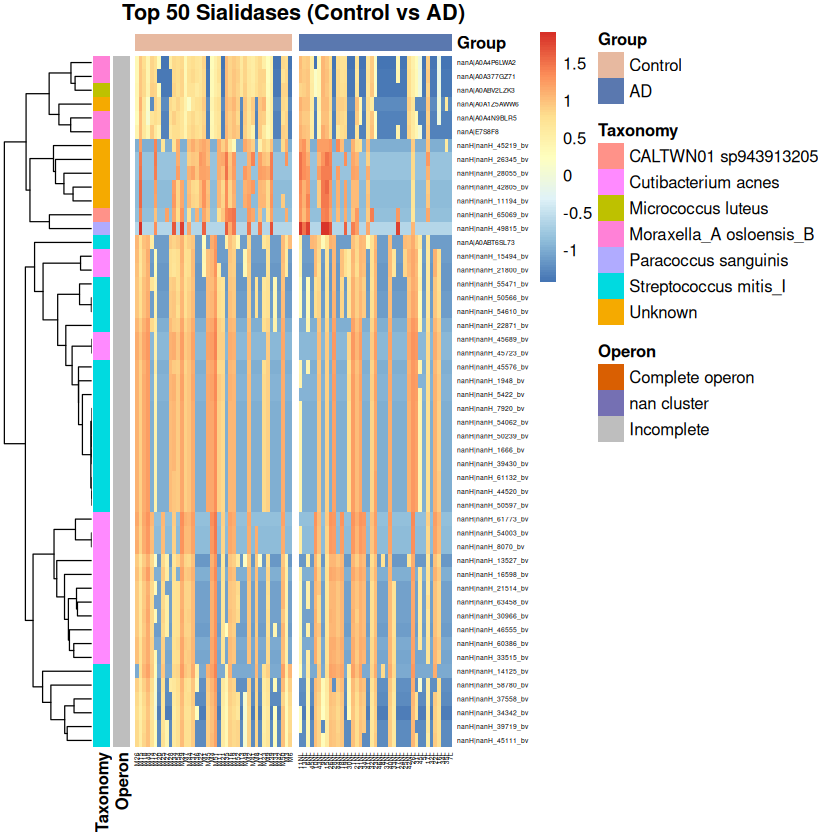

In [14]:
library(pheatmap)
install.packages("svglite")

# 1. Prepare the Matrix with Top 50 Most Variable Proteins
vars <- apply(mat, 1, var)
top <- names(sort(vars, decreasing=TRUE))[1:50]
mat_top <- mat[top, ]
mat_scaled <- t(scale(t(mat_top)))

# 2. Create a new grouping variable with only Control vs AD (combining NC and AD-NL into Control)
grupos_dois <- ifelse(coldata$Group == "Control" | coldata$Group == "NC", "Control", "AD")
coldata$Group_2Levels <- factor(grupos_dois, levels = c("Control", "AD"))

coldata_ordered <- coldata[order(coldata$Group_2Levels), ]
mat_scaled_ordered <- mat_scaled[, rownames(coldata_ordered)]

# 3. Anotation for columns (Clinical Group) - Now with only Control vs AD 
annotation_col_ordered <- data.frame(Group = coldata_ordered$Group_2Levels)
rownames(annotation_col_ordered) <- rownames(coldata_ordered)

tamanhos <- table(coldata_ordered$Group_2Levels)
meu_unico_gap <- c(tamanhos["Control"])

# 4. Carregar Tabela do Python e Preparar Anotação de Linha (Taxonomia e Operon)
tax_table <- read.delim("~/PRJEB59406/ORGANIZED_RESULTS/Final_Table_Taxonomy_Function_gtdb.tsv", sep = "\t")
tax_unique <- tax_table[!duplicated(tax_table$Protein), ]
rownames(tax_unique) <- tax_unique$Protein
tax_top <- tax_unique[top, ]

# --- NOVA LÓGICA DO OPERON ---
# 1. Verifica se os 4 genes estruturais (o "cluster") estão presentes
has_cluster <- (tax_top$has_nanA == "yes" & 
                tax_top$has_nanE == "yes" & 
                tax_top$has_nanK == "yes" & 
                tax_top$has_nanT == "yes")

# 2. Verifica o nanH separadamente
has_H <- (tax_top$has_nanH == "yes")

# 3. Classifica nas 3 categorias exigidas
status_operon <- ifelse(has_cluster & has_H, "Complete operon",
                 ifelse(has_cluster & !has_H, "nan cluster", 
                        "Incomplete"))

# Regra da Taxonomia Inteligente (Espécie -> Gênero -> Unknown)
taxonomia_inteligente <- ifelse(is.na(tax_top$Species) | tax_top$Species == "", tax_top$Genus, tax_top$Species)
taxonomia_inteligente <- ifelse(is.na(taxonomia_inteligente) | taxonomia_inteligente == "", "Unknown", taxonomia_inteligente)

# Criando a anotação lateral
annotation_row <- data.frame(
  Operon = status_operon,
  Taxonomy = taxonomia_inteligente
)
rownames(annotation_row) <- top

# 5. Definir as Cores Exatas (Agora com a nova categoria)
ann_colors = list(
  Group = c("Control" = "#e7b9a0", "AD" = "#5a78af"),
  Operon = c("Complete operon" = "#d95f02",   # Laranja
             "nan cluster" = "#7570b3",       # Roxo/Azul escuro
             "Incomplete" = "gray")           # Cinza
)

# Certifique-se de que o ggplot2 está carregado para podermos usar o ggsave
library(ggplot2)

# 6. Plotar o Heatmap Final na TELA e salvar num objeto chamado "meu_heatmap"
meu_heatmap <- pheatmap(mat_scaled_ordered,
         annotation_col = annotation_col_ordered,
         annotation_row = annotation_row,
         annotation_colors = ann_colors,
         cluster_cols = FALSE,    # Mantém Control na esquerda e AD na direita
         cluster_rows = TRUE,     # Mantém o agrupamento das proteínas
         show_rownames = TRUE,
         show_colnames = TRUE,
         fontsize_col = 4,
         angle_col = 90,
         fontsize_row = 4,
         gaps_col = meu_unico_gap, # Fresta separando os grupos
         main = "Top 50 Sialidases (Control vs AD)",
         filename = NA)            # NA força o gráfico a aparecer na sua tela!

# 7. Exportar o gráfico em altíssima qualidade (SVG)
# O ggplot2 vai pegar a parte gráfica do heatmap ($gtable) e converter para vetor
ggsave("Heatmap_Crosslink_Control_AD.svg", 
       plot = meu_heatmap$gtable, 
       width = 12, 
       height = 8)

print("Gráfico exibido na tela e salvo em formato SVG com sucesso!")
         


beta diversity DESeq2

using ntop=500 top features by variance



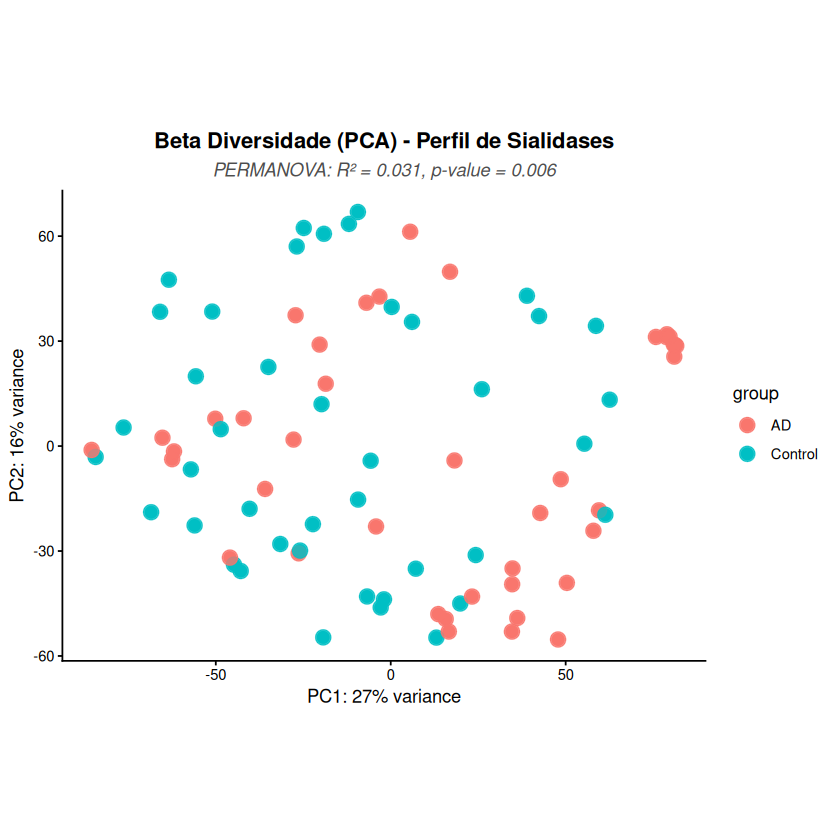

In [5]:
# 1. Carregar os pacotes necessários
library(ggplot2)
if(!require("vegan", quietly = TRUE)) install.packages("vegan")
library(vegan)

# 2. Preparar os dados e rodar a PERMANOVA
# Transpor a matriz para o formato que o pacote vegan exige (amostras nas linhas)
mat_vsd <- t(assay(vsd))
meta_vsd <- as.data.frame(colData(vsd))

# Rodar o teste estatístico (usando 'Group')
set.seed(123) 
permanova_res <- adonis2(mat_vsd ~ Group, 
                         data = meta_vsd, 
                         method = "euclidean", 
                         permutations = 999)

# Extrair os valores estatísticos exatos
r2_value <- round(permanova_res$R2[1], 3)
p_value <- permanova_res$`Pr(>F)`[1]
stats_text <- paste0("PERMANOVA: R² = ", r2_value, ", p-value = ", p_value)

# 3. Plotar o PCA com o DESeq2
pca_plot <- plotPCA(vsd, intgroup = "Group")

# 4. Deixando o gráfico com cara de artigo usando ggplot2 (e adicionando a PERMANOVA)
pca_plot_final <- pca_plot + 
  theme_classic() +
  geom_point(size = 4, alpha = 0.8) +
  ggtitle("Beta Diversidade (PCA) - Perfil de Sialidases") +
  labs(subtitle = stats_text) +                 # <- Adiciona os dados do teste aqui
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5),
    plot.subtitle = element_text(face = "italic", hjust = 0.5, color = "#4d4d4d", size = 11)
  )

# Exibir o gráfico na tela
print(pca_plot_final)

# Para salvar em PDF (opcional, remova o '#' se quiser usar)
ggsave("PCA_Simples_com_PERMANOVA.svg", plot = pca_plot_final, width = 8, height = 6)

In [12]:
# Instalar e carregar o pacote vegan (se necessário)
if(!require("vegan", quietly = TRUE)) install.packages("vegan")
library(vegan)

# 1. Preparar os dados para a PERMANOVA
# O vegan exige que as amostras sejam as linhas e as proteínas sejam as colunas (transposto)
mat_vsd <- t(assay(vsd))

# Extrair os metadados do vsd como um data.frame normal
meta_vsd <- as.data.frame(colData(vsd))

# 2. Executar a PERMANOVA
# set.seed garante que as 999 permutações dêem o mesmo p-valor se você rodar de novo
set.seed(123) 
permanova_res <- adonis2(mat_vsd ~ Group_3Levels, 
                         data = meta_vsd, 
                         method = "euclidean", 
                         permutations = 999)

# Exibir a tabela completa de estatísticas no console
print("Resultados da PERMANOVA:")
print(permanova_res)

# 3. Extrair os valores exatos para o gráfico
r2_value <- round(permanova_res$R2[1], 3)
p_value <- permanova_res$`Pr(>F)`[1]

# Criar o texto que vai no subtítulo
stats_text <- paste0("PERMANOVA: R² = ", r2_value, ", p-value = ", p_value)

# 4. Adicionar o subtítulo ao objeto pca_plot (que criamos no passo anterior)
pca_plot_with_stats <- pca_plot + 
  labs(subtitle = stats_text) +
  theme(plot.subtitle = element_text(hjust = 0.5, face = "italic", color = "#4d4d4d", size = 10))

# Exibir o gráfico atualizado
print(pca_plot_with_stats)

# Salvar o novo PDF
ggsave("PCA_Beta_Diversity_3Groups_PERMANOVA.svg", plot = pca_plot_with_stats, width = 8, height = 6, dpi = 300)

ERROR: Error in eval(predvars, data, env): objeto 'Group_3Levels' não encontrado
